# Objectives


* To explore the convolutional and long short-term neural networks from Week 8 lecture and apply them for forecast of number of days of ground frost and snow based on other weather variables.
> **Remember**: It is your responsibility as a machine learning scientist to read documentations for each library function in the code to thoroughly understand what it is doing, how it serves the purpose highlighted in the code comments, and other parameters that could be set.


# Section 1 - Load new UK Met (60km, 2010-2022) data

Although the same UK Met dataset will be used, the format of the dataset for this week is different from that in Week 3.

1. You need to first download the data before you can get started. Download from the Week 8 page for the module, on Canvas (see 'Week 8 Lab Dataset' on the page). The file you download will be named *curated_data_24month_2010-2022_nonans.csv*.

2. Explore the dataset (see Section 1 of the Week 3 lab notebook for where to get started).

3. Then, use the file menu in Google Colab to upload the file to your Colab directory. Once upload is complete, you should be able to see the file on the listed contents of your Colab directory.

4. You can now run the code in the cell below to load the data.

In [2]:
import csv
import numpy


!ls  /content

data_file_full_path = "/Users/suli/Documents/source/repo/MachineLearning/Week 8/curated_data_24month_2010-2022_nonans.csv"

data_as_list = []

# load the dataset
with open(data_file_full_path) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')

    row_count = 0
    for row in csv_reader:

      if row_count > 0:
        data_as_list.append([float(val) for val in row])
      row_count += 1
data = numpy.array(data_as_list)

# check its shape
print("\n The dataset has shape: "+str(data.shape))


# get features and labels from the data
# based on the objectives (see the Objectives section)
ground_frost_24_col = 27
hurs_1_to_23_col = numpy.arange(ground_frost_24_col+1, ground_frost_24_col+24)
psl_1_to_23_col = hurs_1_to_23_col + 23
sun_1_to_23_col = psl_1_to_23_col + 23
pv_1_to_23_col = sun_1_to_23_col + 23
wind_1_to_23_col = pv_1_to_23_col + 23
tas_1_to_23_col = wind_1_to_23_col + 23
snow_24_col = 97
rain_1_to_23_col = numpy.arange(snow_24_col+1, snow_24_col+24)

# arrange to shape N x T X D
# where N = number of data instances
# T = number of timesteps
# D = number of variables
feats = numpy.stack((data[:, hurs_1_to_23_col], data[:, psl_1_to_23_col],
                     data[:, sun_1_to_23_col], data[:, pv_1_to_23_col],
                     data[:, wind_1_to_23_col], data[:, tas_1_to_23_col],
                     data[:, rain_1_to_23_col]))
feats = numpy.transpose(feats, (1, 2, 0))
ground_frost_label = data[:, ground_frost_24_col]
snow_label = data[:, snow_24_col]

# check its shape
print("\n The reshaped data has shape: "+str(feats.shape))

# take a peek
print("\n A peek at the dataset features: \n"+str(feats))
print("\n A peek at the ground frost labels: \n"+str(ground_frost_label))
print("\n A peek at the snow labels: \n"+str(snow_label))


ls: /content: No such file or directory

 The dataset has shape: (8502, 220)

 The reshaped data has shape: (8502, 23, 7)

 A peek at the dataset features: 
[[[  89.36982749   88.64096898 1019.367542   ...   14.16234929
      4.20105888   69.94420521]
  [  87.17137766 1022.665365   1014.037188   ...   13.56425092
      4.69816926   45.82438428]
  [  82.69586138 1030.782071     64.51156417 ...    9.14180954
      5.90909077    9.12500556]
  ...
  [  87.63357222 1018.310337    317.1626879  ...    5.66678355
      7.16431878   15.57581082]
  [  90.33110135 1016.221761    200.1635946  ...    5.21315437
      9.54317305   15.43351136]
  [  85.49765794 1010.421393    117.0037764  ...    3.96274573
     13.51167177   14.16234929]]

 [[  89.44621093   88.68141089 1019.222602   ...   13.71516642
      4.05930168   69.52167643]
  [  87.15124439 1022.708003   1014.449862   ...   13.28010743
      4.05530053   42.21724   ]
  [  82.37861266 1030.9105       57.48681167 ...    8.8730343
      6.03667

# Section 2 - Split into training, validation, and test sets

In [13]:
from sklearn.model_selection import train_test_split

all_ids = numpy.arange(0, feats.shape[0])

random_seed = 1

# First randomly split the data into 70:30 to get the training set
train_set_ids, rem_set_ids = train_test_split(all_ids, test_size=0.3, train_size=0.7,
                                 random_state=random_seed, shuffle=True)


# Then further split the remaining data 50:50 into validation and test sets
val_set_ids, test_set_ids = train_test_split(rem_set_ids, test_size=0.5, train_size=0.5,
                                 random_state=random_seed, shuffle=True)


train_ground_frost_labels = ground_frost_label[train_set_ids]
train_snow_labels = snow_label[train_set_ids]

val_ground_frost_labels = ground_frost_label[val_set_ids]
val_snow_labels = snow_label[val_set_ids]

test_ground_frost_labels = ground_frost_label[test_set_ids]
test_snow_labels = snow_label[test_set_ids]

print(train_ground_frost_labels.shape)

(5951,)


# Section 3 - Scale (i.e. normalize) the input data

In [14]:
from sklearn.preprocessing import MinMaxScaler

# note that unlike previous weeks
# a normalization is to 0-1 range here
scaled_feats = numpy.reshape(feats, (-1, feats.shape[2]))
scaler = MinMaxScaler()
scaler.fit(scaled_feats)
scaled_feats = scaler.transform(scaled_feats)
scaled_feats = numpy.reshape(scaled_feats, (feats.shape[0], feats.shape[1], feats.shape[2]))
print("\n A peek at the scaled dataset features: \n"+str(scaled_feats))

scaled_train_data = scaled_feats[train_set_ids, :]
scaled_val_data = scaled_feats[val_set_ids, :]
scaled_test_data = scaled_feats[test_set_ids, :]


 A peek at the scaled dataset features: 
[[[0.80064506 0.02645592 0.99150722 ... 0.82249309 0.26487964 0.19439118]
  [0.73380683 0.9914812  0.98630473 ... 0.78168679 0.2874864  0.12383332]
  [0.59774024 0.99986731 0.05955527 ... 0.47995803 0.34255468 0.01647639]
  ...
  [0.74785867 0.98698163 0.30614608 ... 0.24286834 0.39963786 0.03534698]
  [0.82987012 0.98482373 0.19195343 ... 0.21191869 0.50781945 0.03493071]
  [0.68292168 0.97883085 0.11078836 ... 0.12660739 0.68829226 0.03121217]]

 [[0.8029673  0.02649771 0.99136576 ... 0.79198326 0.25843304 0.19315516]
  [0.73319473 0.99152526 0.9867075  ... 0.76230061 0.25825108 0.11328132]
  [0.58809511 1.         0.05269902 ... 0.46162037 0.34835655 0.01556875]
  ...
  [0.69622483 0.98703673 0.28603754 ... 0.23237741 0.3902862  0.03428022]
  [0.81414115 0.98487323 0.17517532 ... 0.19686499 0.51378267 0.03369921]
  [0.69635955 0.979191   0.09751497 ... 0.10996424 0.68439813 0.02990402]]

 [[0.799846   0.02630565 0.9910182  ... 0.78447283 0.2

# Section 4 - Train a convolutional neural network (CNN)

In [15]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error
from copy import deepcopy
import sys
import matplotlib.pyplot as plt



# Creating the network structure
# for a 3-layer CNN
class three_layer_CNN(nn.Module):
    def __init__(self,
                 hidden_layer_channel_sizes,
                 output_size, input_channel_size):
        super().__init__()

        self.hidden_c1 = nn.Conv1d(input_channel_size, hidden_layer_channel_sizes[0], 6, stride=1)
        self.hidden_m1 = (nn.MaxPool1d(3, stride=1))
        self.hidden_c2 = nn.Conv1d(hidden_layer_channel_sizes[0], hidden_layer_channel_sizes[1], 4, stride=1)
        self.hidden_m2 = nn.MaxPool1d(3, stride=1)
        self.hidden_c3 = nn.Conv1d(hidden_layer_channel_sizes[1], hidden_layer_channel_sizes[2], 3, stride=1)
        self.hidden_m3 = nn.MaxPool1d(3, stride=1)
        self.output = nn.Linear(output_size[0], output_size[1])
        self.relu = nn.ReLU()


    def forward(self, inputs):
        out = self.hidden_c1(torch.permute(inputs, (0, 2, 1)))
        out = self.hidden_m1(self.relu(out))
        out = self.hidden_c2(out)
        out = self.hidden_m2(self.relu(out))
        out = self.hidden_c3(out)
        out = self.hidden_m3(self.relu(out))
        out = torch.reshape(out, (out.size(0), -1))
        out = self.output(self.relu(out))
        return out



# a method for training a model
def train_model(model,
                train_set, val_set,
                epochs, learn_rate):

  # Setting up the SGD optimizer for updating the model weights
  optimizer = optim.SGD(model.parameters(), lr=learn_rate)


  # Computing cross entropy loss against the training labels
  loss_function = nn.MSELoss()



  best_model_mae = sys.float_info.max
  losses = []

  # Iterating over the dataset at two different staages:
  # 1. Iterating over the batches in the dataset (inner for loop below)
  # One complete set of iteration through the dataset (i.e. having gone over
  # all batches in the dataset at least once) = One epoch
  # 2. Iterating over the specified numeber of epochs (outer for loop below)
  for epoch in range(0, epochs):

      # Setting the model to training mode
      model.train()

      if epoch == 0:  best_model = deepcopy(model)

      for batch, (X_train, y_train) in enumerate(train_set):

        # Zeroing out the `.grad` buffers,
        # otherwise on the backward pass we'll add the
        # new gradients to the old ones.
        optimizer.zero_grad()

        # Computing the forward pass and then the loss
        train_pred = model.forward(X_train)
        train_loss = loss_function(train_pred, y_train)
        train_pred_numpy = train_pred.detach().numpy()
        train_mae = mean_absolute_error(y_train[:], train_pred_numpy[:])

        # Computing the model parameters' gradients
        # and propagating the loss backwards through the network.
        train_loss.backward()

        # Updating the model parameters using those gradients
        optimizer.step()

      # Evaluating on the validation set
      model.eval()
      for batch, (X_val, y_val) in enumerate(val_set):
        val_pred = model.forward(X_val)
        val_loss = loss_function(val_pred, y_val)
        val_pred_numpy = val_pred.detach().numpy()
        val_mae = mean_absolute_error(y_val[:], val_pred_numpy[:])

      if val_mae <= best_model_mae:
        best_model_mae = val_mae
        best_model = deepcopy(model)
        print('Found improvement in performance. New model saved.')

      # How well the network does at the end of an epoch
      # is an indication of how well training is progressing
      print("epoch: {} - train loss: {:.4f} train mae: {:.2f} val loss: {:.4f} val mae: {:.2f}".format(
          epoch,
          train_loss.item(),
          train_mae,
          val_loss.item(),
          val_mae))

      losses.append([train_loss.item(), val_loss.item()])

  return best_model, losses


# a method for evaluating a model
# including the metrics earlier prepared
# and a graph of the above loss per epoch
def evaluate_model(model,
                test_set,
                training_losses, plot=True, text=''):

  model.eval()
  for batch, (X_test, y_test) in enumerate(test_set):
    test_pred = model.forward(X_test)
    test_pred_numpy = test_pred.detach().numpy()
    test_mae = mean_absolute_error(y_test[:], test_pred_numpy[:])
    print("\n Mean absolute error on the test set{:s}: {:2.2f}".format(text, test_mae))
    print()

  if plot:
    fig, ax = plt.subplots()
    training_losses = numpy.array(training_losses)
    ax.plot(training_losses[:, 0], 'b-', label='training loss')
    ax.plot(training_losses[:, 1], 'k-', label='validation loss')
    plt.legend(loc='upper right')
    plt.xlabel("epochs")
    plt.show




# A class for managing the data for training the model
class MetDataset(Dataset):
    def __init__(self, feats, labels):
        # Convert features from numpy arrays to PyTorch tensors
        self.feats = torch.tensor(feats, dtype=torch.float32)


        # Convert labels from numpy arrays to PyTorch tensors
        self.labels = torch.tensor(numpy.reshape(labels, (-1, 1)), dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        return self.feats[idx, :], self.labels[idx, :]


Found improvement in performance. New model saved.
epoch: 0 - train loss: 12.8491 train mae: 3.58 val loss: 47.2788 val mae: 6.05
Found improvement in performance. New model saved.
epoch: 1 - train loss: 11.2305 train mae: 3.35 val loss: 45.7036 val mae: 5.95
Found improvement in performance. New model saved.
epoch: 2 - train loss: 9.0580 train mae: 3.01 val loss: 43.2458 val mae: 5.77
epoch: 3 - train loss: 14.1287 train mae: 3.76 val loss: 46.6420 val mae: 5.89
epoch: 4 - train loss: 16.3974 train mae: 4.05 val loss: 46.1032 val mae: 5.90
Found improvement in performance. New model saved.
epoch: 5 - train loss: 3.1590 train mae: 1.78 val loss: 18.9398 val mae: 3.54
Found improvement in performance. New model saved.
epoch: 6 - train loss: 0.0018 train mae: 0.04 val loss: 15.2996 val mae: 2.89
epoch: 7 - train loss: 0.3647 train mae: 0.60 val loss: 16.1968 val mae: 2.93
epoch: 8 - train loss: 0.7379 train mae: 0.86 val loss: 16.4752 val mae: 2.93
epoch: 9 - train loss: 1.3008 train mae

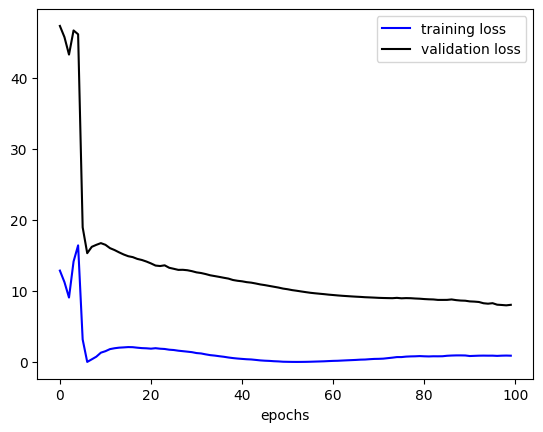

In [10]:
import random

# To ensure reproducibility
# for PyTorch operations that use random numbers internally
random.seed(random_seed)
torch.manual_seed(random_seed)
numpy.random.seed(random_seed)

# Create an instance of the CNN network
input_channel_size_cnn = 7
hidden_layer_sizes_cnn = [7, 30, 7]
output_sizes_cnn = [hidden_layer_sizes_cnn[2]*7, 1]
model_CNN = three_layer_CNN(hidden_layer_sizes_cnn, output_sizes_cnn, input_channel_size_cnn)


# Set hyperparameters
num_epochs_CNN = 100
learning_rate_CNN = 0.0005
batch_size = 50


# Set up the data loading by batches
# With the test and validation sets having only one batch
train_set = MetDataset(scaled_train_data, train_ground_frost_labels)
train_dataloader = DataLoader(train_set, batch_size=batch_size)

val_set = MetDataset(scaled_val_data, val_ground_frost_labels)
val_dataloader = DataLoader(val_set, batch_size=len(val_set))

test_set = MetDataset(scaled_test_data, test_ground_frost_labels)
test_dataloader = DataLoader(test_set, batch_size=len(test_set))



# train the model
model_CNN, train_val_losses_CNN = train_model(model_CNN, train_dataloader,
                                                          val_dataloader,
                                                          num_epochs_CNN,
                                                          learning_rate_CNN)

# evaluate the model
evaluate_model(model_CNN, test_dataloader, train_val_losses_CNN)



# Section 5 - Explore the CNN

* For each layer of the CNN in Section 4, calculate the dimension of the output of the layer. (Hint: See Week 8 lecture slides for the formulae for computing the output dimension of a convolutional layer. The same formula applies to pooling layers.)

* Based on your calculations above and the structure of the CNN, how many parameters does the model have? How does this compare with the number of parameters if each convolutional layer was instead a fully connected layer.

* Perform data augmentation (see Week 5 lecture), e.g.
  * dropout along the time dimension,
  * dropout along the variable dimension,
  * random noise along the time dimension.

* How does the augmentation affect generalisation of the model?

**Solution**

* The shapes of the output of each layer of the CNN are:
  * Input - B x 7 x 23
  * Conv layer 1 - B x 7 x 18
  * Max pool layer 1 - B x 7 x 16
  * Conv layer 2 - B x 30 x 13
  * Max pool layer 2 - B x 30 x 11
  * Conv layer 3 - B x 7 x 9
  * Max pool layer 3 - B x 7 x 7
  * MLP layer - B x 1


* The numbers of parameters (weights) for each of the above layers are:
  * Input - 0 (as this just represents the data, i.e. no function is applied)
  * Conv layer 1 - (6 x 7 x 7) + 1 = 295 (6 is equivalent to the kernel size for this layer, 7 is the channel size for its input, the second 7 is the channel size for its output, and 1 is for the bias)
  * Max pool layer 1 - 0 (max pooling, and activation functions, do not apply weights)
  * Conv layer 2 - (4 x 7 x 30) + 1 = 841 (same as above)
  * Max pool layer 2 - 0 (same as above)
  * Conv layer 3 - (3 x 30 x 7) + 1 = 631 (same as above)
  * Max pool layer 3 - 0 (same as above)
  * MLP layer - (7 x 7) + 1 = 50 (equivalent to the size, for a given data instance, of the input to this layer)
  * TOTAL = 295 + 841 + 631 + 50 = 1,817
  

* Replacing each convolutional layer with a fully connected layer, the numbers of parameters (weights) would be:
  * Input - 0 (as this just represents the data, i.e. no function is applied)
  * MLP layer 1 - (7 x 23 x 7 x 18) + 1 = 20,287 (7 x 23 is equivalent to the size of the input to this layer, 7 x 18 is the size of its output, and 1 is for the bias)
  * Max pool layer 1 - 0
  * MLP layer 2 - (7 x 16 x 30 x 13) + 1 = 43,681 (same as above)
  * Max pool layer 2 - 0
  * MLP layer 3 - (30 x 11 x 7 x 9) + 1 = 20,791 (same as above)
  * Max pool layer 3 - 0
  * MLP layer 4 - (7 x 7) + 1  = 50
  * TOTAL = 20,287 + 43,681 + 20,791 + 50 = 84,809

* To enable robustness to missing sensors and noisy data, dropout was applied to the variable dimension and random noise added to the data. See code below.

* Although performance with augmentation is lower compared to no augmentation (based on performance on the original test data), robustness with augmentation is higher. The model without augmentation performed worse when the test data was noisy and missing values compared to its performance without noise and with no values missing, while the model with augmentation performed the same with noise and missing values as without.

In [6]:


# Creating the network structure
# for a 3-layer CNN
# with dropout and random noise added to the input
class three_layer_CNN_aug(nn.Module):
    def __init__(self,
                 hidden_layer_channel_sizes,
                 output_size, input_channel_size):
        super().__init__()

        self.hidden_c1 = nn.Conv1d(input_channel_size, hidden_layer_channel_sizes[0], 6, stride=1)
        self.hidden_m1 = (nn.MaxPool1d(3, stride=1))
        self.hidden_c2 = nn.Conv1d(hidden_layer_channel_sizes[0], hidden_layer_channel_sizes[1], 4, stride=1)
        self.hidden_m2 = nn.MaxPool1d(3, stride=1)
        self.hidden_c3 = nn.Conv1d(hidden_layer_channel_sizes[1], hidden_layer_channel_sizes[2], 3, stride=1)
        self.hidden_m3 = nn.MaxPool1d(3, stride=1)
        self.output = nn.Linear(output_size[0], output_size[1])
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout2d(0.01)


    def forward(self, inputs):

        # apply dropout along the variable dimension for each data instance
        out = torch.permute(inputs, (0, 2, 1))
        out = torch.reshape(out, (out.size(0), out.size(1), out.size(2), 1))
        out = self.dropout(out)
        out = torch.reshape(out, (out.size(0), out.size(1), out.size(2)))

        out = self.hidden_c1(out)
        out = self.hidden_m1(self.relu(out))
        out = self.hidden_c2(out)
        out = self.hidden_m2(self.relu(out))
        out = self.hidden_c3(out)
        out = self.hidden_m3(self.relu(out))
        out = torch.reshape(out, (out.size(0), -1))
        out = self.output(self.relu(out))
        return out



# A class for managing the data for training the model
class MetDataset_aug(Dataset):
    def __init__(self, feats, labels):
        # Convert features from numpy arrays to PyTorch tensors
        # 1.0 is added to shift the scale of the data from [0, 1] to [1, 2]
        # so that implementing dropout as turning values to 0
        # does not clash with values that were genuinely of value 0
        self.feats = torch.tensor(feats + 1.0, dtype=torch.float32)

        # Convert labels from numpy arrays to PyTorch tensors
        self.labels = torch.tensor(numpy.reshape(labels, (-1, 1)), dtype=torch.float32)


    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        return self.feats[idx, :], self.labels[idx, :]


Found improvement in performance. New model saved.
epoch: 0 - train loss: 58.3825 train mae: 7.64 val loss: 87.3794 val mae: 7.06
Found improvement in performance. New model saved.
epoch: 1 - train loss: 13.2854 train mae: 3.64 val loss: 70.8973 val mae: 6.55
Found improvement in performance. New model saved.
epoch: 2 - train loss: 12.9946 train mae: 3.60 val loss: 70.6268 val mae: 6.54
Found improvement in performance. New model saved.
epoch: 3 - train loss: 13.1992 train mae: 3.63 val loss: 70.5426 val mae: 6.54
Found improvement in performance. New model saved.
epoch: 4 - train loss: 12.8640 train mae: 3.59 val loss: 70.2682 val mae: 6.52
Found improvement in performance. New model saved.
epoch: 5 - train loss: 12.7336 train mae: 3.57 val loss: 69.9912 val mae: 6.51
Found improvement in performance. New model saved.
epoch: 6 - train loss: 12.7607 train mae: 3.57 val loss: 69.6839 val mae: 6.50
Found improvement in performance. New model saved.
epoch: 7 - train loss: 12.6716 train ma

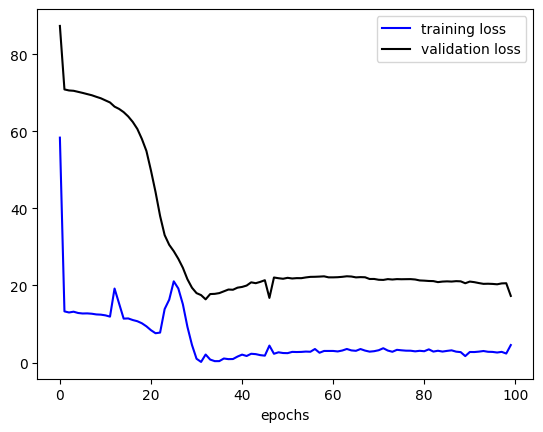

In [7]:
# Ensure reproducibility comparability with Section 4
# for PyTorch operations that use random numbers internally
random.seed(random_seed)
torch.manual_seed(random_seed)
numpy.random.seed(random_seed)

# Create an instance of the CNN network
model_CNN_aug = three_layer_CNN_aug(hidden_layer_sizes_cnn, output_sizes_cnn, input_channel_size_cnn)


# Reset hyperparameters
# The learning rate was adapted based on experimentation
num_epochs_CNN_aug = 100
learning_rate_CNN_aug = 0.0001


# Set up the data loading by batches
# With the test and validation sets having only one batch
# noise is only added for the training
#   create different noise values (mean=0, standard deviation=0.0001)
#   for each timestep of each variable of each data instance,
#   and add the noise to the input
# Set up the random number generator

rng =  numpy.random.default_rng()
noise = rng.normal(loc=0.0, scale=0.0001, size=scaled_train_data.shape)
noised_scaled_train_data = scaled_train_data + noise
train_set_aug = MetDataset_aug(noised_scaled_train_data, train_ground_frost_labels)
train_dataloader_aug = DataLoader(train_set_aug, batch_size=batch_size)

val_set_aug = MetDataset_aug(scaled_val_data, val_ground_frost_labels)
val_dataloader_aug = DataLoader(val_set, batch_size=len(val_set))

test_set_aug = MetDataset_aug(scaled_test_data, test_ground_frost_labels)
test_dataloader_aug = DataLoader(test_set_aug, batch_size=len(test_set))

# randomly select a variable to have all its values missing
# and randomly add noise to the other variables
noisy_scaled_test_data = scaled_test_data + rng.normal(loc=0.0, scale=0.0005, size=scaled_test_data.shape)
col = rng.integers(low=0, high=scaled_test_data.shape[2])
noisy_scaled_test_data[:, :, col] = numpy.zeros((scaled_test_data.shape[0], scaled_test_data.shape[1]))
test_set_aug_noised = MetDataset_aug(noisy_scaled_test_data, test_ground_frost_labels)
test_dataloader_aug_noised = DataLoader(test_set_aug, batch_size=len(test_set))


# train the model
model_CNN_aug, train_val_losses_CNN_aug = train_model(model_CNN_aug, train_dataloader_aug,
                                                          val_dataloader_aug,
                                                          num_epochs_CNN_aug,
                                                          learning_rate_CNN_aug)



# evaluate the model
evaluate_model(model_CNN_aug, test_dataloader_aug, train_val_losses_CNN_aug, text=' (Aug_model, Unnoised_data)')

# evaluate the model on the noised test data
evaluate_model(model_CNN_aug, test_dataloader_aug_noised, train_val_losses_CNN_aug, plot=False, text=' (Aug_model, Noised_data)')

# evaluate the original model on the noised test data
evaluate_model(model_CNN, test_dataloader_aug_noised, train_val_losses_CNN, plot=False, text=' (Unaug_model, Noised_data)')



# Section 6 - Train a long short-term memory neural network (LSTMNN)

* Create and train a three-layer LSTMNN model (see https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html for the documentation for the PyTorch LSTM layer)

* How many weights does the LSTMNN have?

* How does your model perform in comparison with the CNN in Section 4?

**Solution**

* See below for code creating and training a three-layer LSTMNN

* You could have manually computed the number of parameters per layer as done in Section 5, based on the knowledge of the structure of a LSTM layer. The last code cell below computes the number of parameters per layer for you. The total number of weights (including biases) is 6,228.

* The performance is lower than for the CNN in Section 4. The higher number of parameters could have contributed to this. You could try optimizing the hyperparameters of the model to see if you could obtain a LSTMNN model that matches the performance of the CNN in Section 4.




In [8]:

# Creating the network structure
# for a 3-layer LSTMNN
class three_layer_LSTMNN(nn.Module):
    def __init__(self,
                 hidden_layer_sizes,
                 output_sizes,
                 input_channel_size):
        super().__init__()

        self.hidden_r1 = nn.LSTM(input_channel_size, hidden_layer_sizes[0], batch_first=True)
        self.hidden_r2 = nn.LSTM(hidden_layer_sizes[0], hidden_layer_sizes[1], batch_first=True)
        self.hidden_r3 = nn.LSTM(hidden_layer_sizes[1], hidden_layer_sizes[2], batch_first=True)
        self.output = nn.Linear(output_sizes[0], output_sizes[1])

        self.tanh = nn.Tanh()



    def forward(self, inputs):
        out = self.hidden_r1(inputs)
        out = self.hidden_r2(self.tanh(out[0]))
        out = self.hidden_r3(self.tanh(out[0]))
        out = self.tanh(out[1][0])
        out = torch.reshape(out, (-1, out.size(2)))
        out = self.output(out)
        return out



Found improvement in performance. New model saved.
epoch: 0 - train loss: 132.4188 train mae: 11.51 val loss: 112.6095 val mae: 8.13
Found improvement in performance. New model saved.
epoch: 1 - train loss: 129.0600 train mae: 11.36 val loss: 110.2445 val mae: 7.98
Found improvement in performance. New model saved.
epoch: 2 - train loss: 125.7788 train mae: 11.22 val loss: 107.9464 val mae: 7.86
Found improvement in performance. New model saved.
epoch: 3 - train loss: 122.5556 train mae: 11.07 val loss: 105.7012 val mae: 7.75
Found improvement in performance. New model saved.
epoch: 4 - train loss: 119.3727 train mae: 10.93 val loss: 103.4964 val mae: 7.65
Found improvement in performance. New model saved.
epoch: 5 - train loss: 116.2161 train mae: 10.78 val loss: 101.3227 val mae: 7.56
Found improvement in performance. New model saved.
epoch: 6 - train loss: 113.0761 train mae: 10.63 val loss: 99.1735 val mae: 7.47
Found improvement in performance. New model saved.
epoch: 7 - train lo

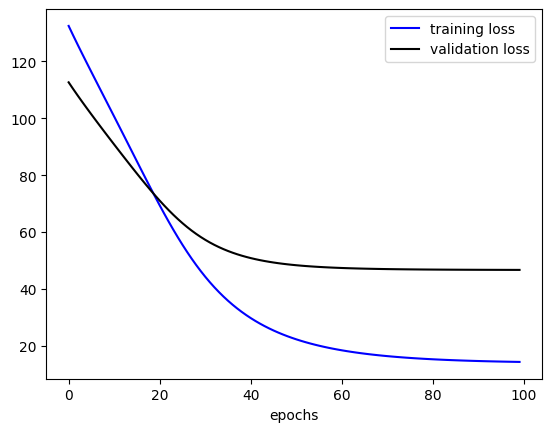

In [9]:
# Ensure reproducibility comparability with Section 4
# for PyTorch operations that use random numbers internally
random.seed(random_seed)
torch.manual_seed(random_seed)
numpy.random.seed(random_seed)

# Creating an instance of the LSTM network
input_channel_size_lstm = 7
hidden_layer_sizes_lstm = [7, 30, 7]
output_sizes_lstm = [hidden_layer_sizes_lstm[2], 1]
model_LSTMNN = three_layer_LSTMNN(hidden_layer_sizes_lstm, output_sizes_lstm, input_channel_size_lstm)


# Setting hyperparameters
num_epochs_LSTMNN = 100
learning_rate_LSTMNN = 0.00005



# training the model
model_LSTMNN, train_val_losses_LSTMNN = train_model(model_LSTMNN,
                                              train_dataloader,
                                              val_dataloader,
                                              num_epochs_LSTMNN,
                                              learning_rate_LSTMNN)

# evaluating the model
evaluate_model(model_LSTMNN, test_dataloader, train_val_losses_LSTMNN)


In [10]:
total_params = sum(w.numel() for w in model_LSTMNN.parameters())
print("Number of parameters: ", total_params)

Number of parameters:  6228
